In [1]:
!pip install seaborn
!pip install networkx

    100% |████████████████████████████████| 163kB 2.9MB/s ta 0:00:01
  Running setup.py bdist_wheel for seaborn ... - done
  Stored in directory: /root/.cache/pip/wheels/cb/c8/67/83d615c0ef9b529558525aa521025b183de8c5b156799b091e
Successfully built seaborn
    100% |████████████████████████████████| 1.3MB 1.0MB/s eta 0:00:01


Shallow Benchmark
in this script we will explore perhaps the most trivial benchmark one can think of:
extraction of "bag of words"/"bag of letter sequences" features followed by a logistic regression classifier
Note: due to runtime limitation in the kernels platform one cannot really run this script to get a reasonable LB score, so you will have to run it locally on your computer and change some of the script parameters in CountVectorizer:
max_features = 300000
min_df = 50
ngram_range = (1,10)
On my laptop, this script with the above parameters runs for a little less than an hour, and achieves a LB score of 0.31675

In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn import model_selection
from sklearn import linear_model

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

matplotlib.style.use('fivethirtyeight')

In [3]:
#%% load train data

trainDF = pd.read_csv('train.csv')
trainDF = trainDF.dropna(how="any").reset_index(drop=True)

trainDF.ix[:7,3:]

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,How can I be a good geologist?,What should I do to be a great geologist?,1


In [4]:
#%% create dictionary and extract BOW features from questions

featureExtractionStartTime = time.time()

maxNumFeatures = 300000

# bag of letter sequences (chars)
BagOfWordsExtractor = CountVectorizer(max_df=0.999, min_df=50, max_features=maxNumFeatures, 
                                      analyzer='char', ngram_range=(1,10), 
                                      binary=True, lowercase=True)
# bag of words
#BagOfWordsExtractor = CountVectorizer(max_df=0.999, min_df=10, max_features=maxNumFeatures, 
#                                      analyzer='word', ngram_range=(1,6), stop_words='english', 
#                                      binary=True, lowercase=True)

BagOfWordsExtractor.fit(pd.concat((trainDF.ix[:,'question1'],trainDF.ix[:,'question2'])).unique())

trainQuestion1_BOW_rep = BagOfWordsExtractor.transform(trainDF.ix[:,'question1'])
trainQuestion2_BOW_rep = BagOfWordsExtractor.transform(trainDF.ix[:,'question2'])
lables = np.array(trainDF.ix[:,'is_duplicate'])

featureExtractionDurationInMinutes = (time.time()-featureExtractionStartTime)/60.0
print("feature extraction took %.2f minutes" % (featureExtractionDurationInMinutes))

feature extraction took 16.12 minutes


In [5]:
0#%% prefrom cross validation

crossValidationStartTime = time.time()

numCVSplits = 8
numSplitsToBreakAfter = 2

X = -(trainQuestion1_BOW_rep != trainQuestion2_BOW_rep).astype(int)
#X = -(trainQuestion1_BOW_rep != trainQuestion2_BOW_rep).astype(int) + \
#      trainQuestion1_BOW_rep.multiply(trainQuestion2_BOW_rep)
y = lables

logisticRegressor = linear_model.LogisticRegression(C=0.1, solver='sag')

logRegAccuracy = []
logRegLogLoss = []
logRegAUC = []

print('---------------------------------------------')
stratifiedCV = model_selection.StratifiedKFold(n_splits=numCVSplits, random_state=2)
for k, (trainInds, validInds) in enumerate(stratifiedCV.split(X, y)):
    foldTrainingStartTime = time.time()

    X_train_cv = X[trainInds,:]
    X_valid_cv = X[validInds,:]

    y_train_cv = y[trainInds]
    y_valid_cv = y[validInds]

    logisticRegressor.fit(X_train_cv, y_train_cv)

    y_train_hat =  logisticRegressor.predict_proba(X_train_cv)[:,1]
    y_valid_hat =  logisticRegressor.predict_proba(X_valid_cv)[:,1]

    logRegAccuracy.append(accuracy_score(y_valid_cv, y_valid_hat > 0.5))
    logRegLogLoss.append(log_loss(y_valid_cv, y_valid_hat))
    logRegAUC.append(roc_auc_score(y_valid_cv, y_valid_hat))
    
    foldTrainingDurationInMinutes = (time.time()-foldTrainingStartTime)/60.0
    print('fold %d took %.2f minutes: accuracy = %.3f, log loss = %.4f, AUC = %.3f' % (k+1,
             foldTrainingDurationInMinutes, logRegAccuracy[-1],logRegLogLoss[-1],logRegAUC[-1]))

    if (k+1) >= numSplitsToBreakAfter:
        break


crossValidationDurationInMinutes = (time.time()-crossValidationStartTime)/60.0

print('---------------------------------------------')
print('cross validation took %.2f minutes' % (crossValidationDurationInMinutes))
print('mean CV: accuracy = %.3f, log loss = %.4f, AUC = %.3f' % (np.array(logRegAccuracy).mean(),
                                                                 np.array(logRegLogLoss).mean(),
                                                                 np.array(logRegAUC).mean()))
print('---------------------------------------------')

---------------------------------------------


/usr/local/lib/python2.7/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


fold 1 took 4.18 minutes: accuracy = 0.846, log loss = 0.3519, AUC = 0.919
fold 2 took 3.99 minutes: accuracy = 0.844, log loss = 0.3553, AUC = 0.917
---------------------------------------------
cross validation took 8.22 minutes
mean CV: accuracy = 0.845, log loss = 0.3536, AUC = 0.918
---------------------------------------------


In [9]:
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


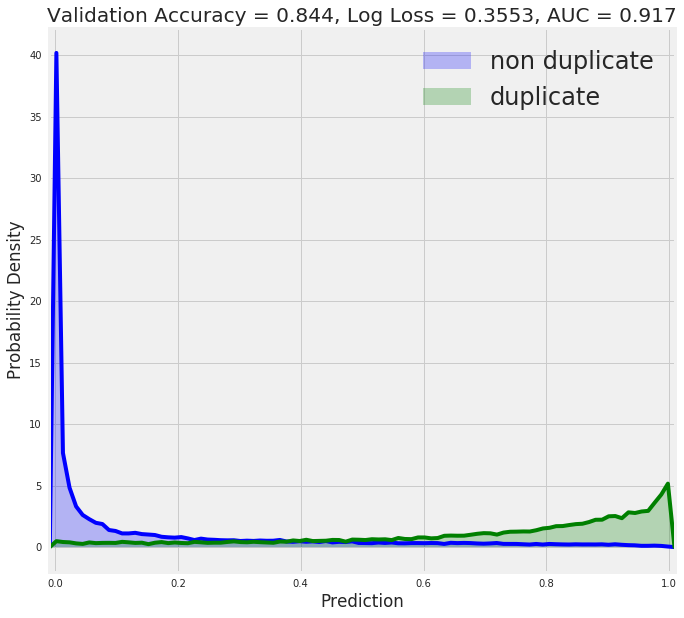

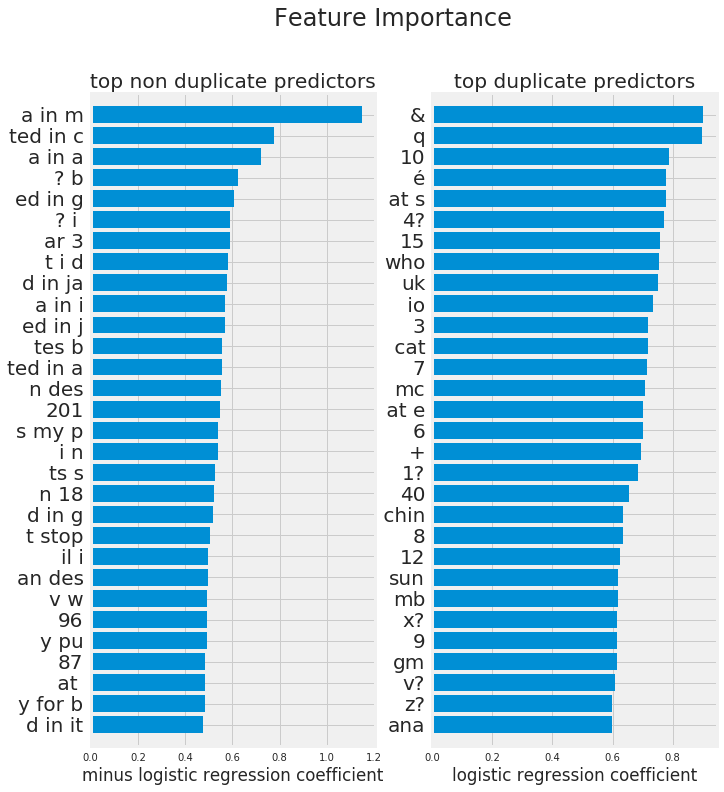

In [10]:
9#%% show prediction distribution and "feature importance"

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.figure(); 
sns.kdeplot(y_valid_hat[y_valid_cv==0], shade=True, color="b", bw=0.01)
sns.kdeplot(y_valid_hat[y_valid_cv==1], shade=True, color="g", bw=0.01)
plt.legend(['non duplicate','duplicate'],fontsize=24)
plt.title('Validation Accuracy = %.3f, Log Loss = %.4f, AUC = %.3f' %(logRegAccuracy[-1],
                                                                      logRegLogLoss[-1],
                                                                      logRegAUC[-1]))
plt.xlabel('Prediction'); plt.ylabel('Probability Density'); plt.xlim(-0.01,1.01)


numFeaturesToShow = 30

sortedCoeffients = np.sort(logisticRegressor.coef_)[0]
featureNames = BagOfWordsExtractor.get_feature_names()
sortedFeatureNames = [featureNames[x] for x in list(np.argsort(logisticRegressor.coef_)[0])]

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10,12)

plt.figure()
plt.suptitle('Feature Importance',fontsize=24)
ax = plt.subplot(1,2,1); plt.title('top non duplicate predictors'); 
plt.xlabel('minus logistic regression coefficient')
ax.barh(range(numFeaturesToShow), -sortedCoeffients[:numFeaturesToShow][::-1], align='center'); 
plt.ylim(-1,numFeaturesToShow); ax.set_yticks(range(numFeaturesToShow)); 
ax.set_yticklabels(sortedFeatureNames[:numFeaturesToShow][::-1],fontsize=20)

ax = plt.subplot(1,2,2); plt.title('top duplicate predictors'); 
plt.xlabel('logistic regression coefficient')
ax.barh(range(numFeaturesToShow), sortedCoeffients[-numFeaturesToShow:], align='center'); 
plt.ylim(-1,numFeaturesToShow); ax.set_yticks(range(numFeaturesToShow)); 
ax.set_yticklabels(sortedFeatureNames[-numFeaturesToShow:],fontsize=20)

In [11]:
#%% train on full training data

trainingStartTime = time.time()

logisticRegressor = linear_model.LogisticRegression(C=0.1, solver='sag', 
                                                    class_weight={1: 0.46, 0: 1.32})
logisticRegressor.fit(X, y)

trainingDurationInMinutes = (time.time()-trainingStartTime)/60.0
print('full training took %.2f minutes' % (trainingDurationInMinutes))#%% train on full training data

trainingStartTime = time.time()

logisticRegressor = linear_model.LogisticRegression(C=0.1, solver='sag', 
                                                    class_weight={1: 0.46, 0: 1.32})
logisticRegressor.fit(X, y)

trainingDurationInMinutes = (time.time()-trainingStartTime)/60.0
print('full training took %.2f minutes' % (trainingDurationInMinutes))

full training took 4.41 minutes
full training took 4.38 minutes


predicting on test took 44.35 minutes


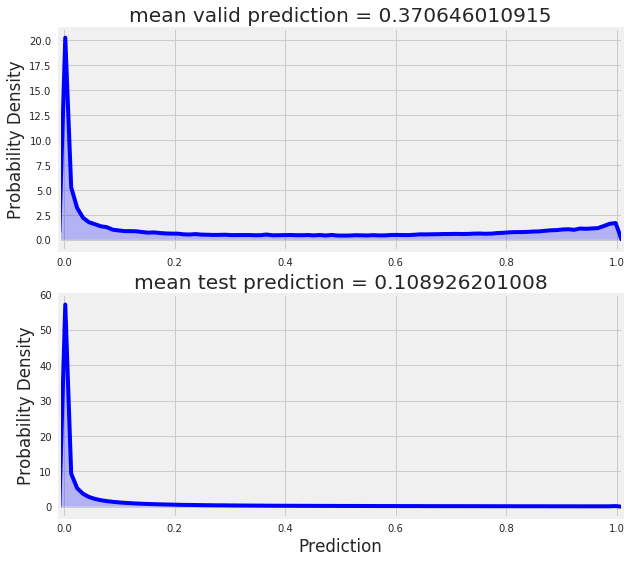

In [12]:
0#%% load test data, extract features and make predictions

testPredictionStartTime = time.time()

testDF = pd.read_csv('test.csv')
testDF.ix[testDF['question1'].isnull(),['question1','question2']] = 'random empty question'
testDF.ix[testDF['question2'].isnull(),['question1','question2']] = 'random empty question'

testQuestion1_BOW_rep = BagOfWordsExtractor.transform(testDF.ix[:,'question1'])
testQuestion2_BOW_rep = BagOfWordsExtractor.transform(testDF.ix[:,'question2'])

X_test = -(testQuestion1_BOW_rep != testQuestion2_BOW_rep).astype(int)
#X_test = -(testQuestion1_BOW_rep != testQuestion2_BOW_rep).astype(int) + \
#           testQuestion1_BOW_rep.multiply(testQuestion2_BOW_rep)

#testPredictions = logisticRegressor.predict_proba(X_test)[:,1]

# quick fix to avoid memory errors
seperators= [750000,1500000]
testPredictions1 = logisticRegressor.predict_proba(X_test[:seperators[0],:])[:,1]
testPredictions2 = logisticRegressor.predict_proba(X_test[seperators[0]:seperators[1],:])[:,1]
testPredictions3 = logisticRegressor.predict_proba(X_test[seperators[1]:,:])[:,1]
testPredictions = np.hstack((testPredictions1,testPredictions2,testPredictions3))

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9,9)

plt.figure(); 
plt.subplot(2,1,1); sns.kdeplot(y_valid_hat, shade=True, color="b", bw=0.01); 
plt.ylabel('Probability Density'); plt.xlim(-0.01,1.01)
plt.title('mean valid prediction = ' + str(np.mean(y_valid_hat)))
plt.subplot(2,1,2); sns.kdeplot(testPredictions, shade=True, color="b", bw=0.01);
plt.xlabel('Prediction'); plt.ylabel('Probability Density'); plt.xlim(-0.01,1.01)
plt.title('mean test prediction = ' + str(np.mean(testPredictions)))

testPredictionDurationInMinutes = (time.time()-testPredictionStartTime)/60.0
print('predicting on test took %.2f minutes' % (testPredictionDurationInMinutes))

In [13]:
#%% create a submission

submissionName = 'shallowBenchmark'

submission = pd.DataFrame()
submission['test_id'] = testDF['test_id']
submission['is_duplicate'] = testPredictions
submission.to_csv(submissionName + '.csv', index=False)